# Postprocessing for the eigenvalue solutions

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, h5py
from pg_utils.processing import postproc as pproc

## Matrix visualization

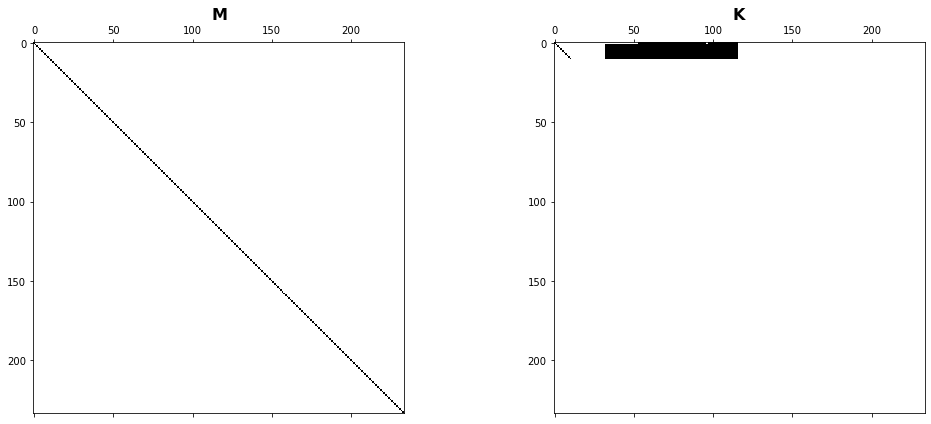

In [5]:
# matrix_file = "./out/cases/Malkus/Reduced_sys/Matrix_eval.h5"
matrix_file = "./out/cases/Hydrodynamic/Recipe_Conjugate/Matrix_eval_N10.h5"

with h5py.File(matrix_file, 'r') as fread:
    M_tmp = fread["M"][()]
    K_tmp = fread["K"][()]

visual_prec = 1e-12
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax = axes[0]
ax.spy(M_tmp, precision=visual_prec)
ax.set_title(r"$\mathbf{M}$", fontsize=16)

ax = axes[1]
ax.spy(K_tmp, precision=visual_prec)
ax.set_title(r"$\mathbf{K}$", fontsize=16)

plt.tight_layout()
plt.savefig("./out/imgs/sparsity__hydrodynamic_cg.png", format="png", bbox_inches="tight")
plt.show()

## Compare eigenvalues

Read in eigenvalue solutions

In [47]:
solution_file_list = [
    
    # # Different recipes for Malkus bg field
    # "./out/solutions/Malkus/Eigen_recipe-Daria_mm.hdf5", 
    # "./out/solutions/Malkus/Eigen_recipe-Daria.h5", 
    # "./out/solutions/Malkus/Eigen_recipe-Daria_scipy.h5", 
    # "./out/cases/Malkus/MM_recipe/Eigen.h5",
    # "./out/cases/Malkus/MM_quad_Malkus/Eigen.h5",
    
    # # Final three approaches for Malkus bg field
    # "./out/cases/Malkus/Full_recipe_Daria_thesis/Eigen.h5",
    # "./out/cases/Malkus/Conjugate_recipe/Eigen.h5", 
    # "./out/cases/Malkus/Reduced_sys/Eigen.h5",
    
    # Hydrodynamic modes
    "./out/cases/Hydrodynamic/Recipe_Conjugate/Eigen_N100.h5",
]
src_names = [
    
    # # Different recipes for Malkus bg field
    # "Code Daria Mathematica", 
    # "PlesioGeostroPy-mp32", 
    # "PlesioGeostroPy-scipy", 
    # "PlesioGeostroPy-PG-Daria",
    # "PlesioGeostroPy: Recipe Daria quad_Malkus",
    
    # # Final three approaches for Malkus bg field
    # "Recipe Holdenried-Chernoff (2021)",
    # "Conjugate variables", 
    # "Reduced system",
    
    # Hydrodynamic modes
    "Conjugate variables",
]

solution_list = list()
for idx, fname in enumerate(solution_file_list):
    with h5py.File(fname, 'r') as f:
        solution_list.append(f["eigval"][()])

if "Mathematica" in src_names[0].split():
    solution_list[0] = 1j*solution_list[0]

Sort east/west modes

In [48]:
df_east = pd.DataFrame()
df_west = pd.DataFrame()

for idx, srcname in enumerate(src_names):
    eig_val_tmp = solution_list[idx]
    eigidx_east = np.arange(eig_val_tmp.size)[np.imag(eig_val_tmp) < -1e-5]
    eigidx_west = np.arange(eig_val_tmp.size)[np.imag(eig_val_tmp) > +1e-5]
    df_east[srcname] = eig_val_tmp[eigidx_east]
    df_west[srcname] = np.flip(eig_val_tmp[eigidx_west])

Load analytical

In [49]:
from pg_utils.numerics import utils as nutils

n_eigs = np.arange(1, 102)
# omega_fast, omega_slow = nutils.eigenfreq_Malkus_pg(3, n_eigs, 1e-4, mode="all", timescale="alfven")
omega_inertial = nutils.eigenfreq_psi_op(3, n_eigs)

df_east["Analytic PG"] = omega_inertial*1j
# df_west["Analytic PG"] = omega_slow*1j

# omega_fast, omega_slow = nutils.eigenfreq_Malkus_3d(3, n_eigs, 1e-4, mode="all", timescale="alfven")
omega_inertial_3d = nutils.eigenfreq_inertial3d(3, n_eigs)

df_east["Analytic 3D"] = omega_inertial_3d*1j
# df_west["Analytic 3D"] = omega_slow*1j

Output

In [50]:
df_east.transpose().style.format(formatter=lambda x: "{0.real:.2e},{0.imag:.7e}j".format(x))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
Conjugate variables,"0.00e+00,-2.3529412e-01j","-1.41e-17,-1.1650485e-01j","0.00e+00,-7.0175439e-02j","-1.39e-17,-4.7058824e-02j","6.10e-30,-3.3802817e-02j","3.47e-18,-2.5477707e-02j","-3.47e-18,-1.9900498e-02j","1.83e-25,-1.5978695e-02j","5.20e-18,-1.3114754e-02j","1.73e-18,-1.0958904e-02j","-3.96e-26,-9.2951201e-03j","-1.73e-18,-7.9840319e-03j","-8.67e-19,-6.9324090e-03j","-8.67e-19,-6.0759494e-03j","-8.67e-19,-5.3691275e-03j","9.15e-24,-4.7789725e-03j","-8.67e-19,-4.2811274e-03j","-2.86e-23,-3.8572806e-03j","4.34e-19,-3.4934498e-03j","8.67e-19,-3.1788079e-03j","-4.34e-19,-2.9048656e-03j","4.34e-19,-2.6648901e-03j","8.67e-19,-2.4534860e-03j","-4.34e-19,-2.2662890e-03j","-4.34e-19,-2.0997375e-03j","-6.51e-19,-1.9509023e-03j","8.81e-19,-1.8173557e-03j","8.58e-19,-1.6970725e-03j","-6.50e-19,-1.5883521e-03j","-2.29e-21,-1.4897579e-03j","-6.06e-23,-1.4000700e-03j","8.21e-22,-1.3182467e-03j","-6.62e-22,-1.2433945e-03j","8.67e-19,-1.1747430e-03j","1.09e-18,-1.1116258e-03j","1.08e-18,-1.0534633e-03j","8.70e-19,-9.9975006e-04j","2.17e-19,-9.5004354e-04j","5.42e-19,-9.0395480e-04j","3.24e-19,-8.6114101e-04j","-2.18e-19,-8.2129902e-04j","3.25e-19,-7.8415997e-04j","-2.27e-22,-7.4948473e-04j","1.08e-19,-7.1706005e-04j","-1.10e-19,-6.8669528e-04j","1.08e-19,-6.5821952e-04j","1.08e-19,-6.3147924e-04j","2.17e-19,-6.0633621e-04j","2.17e-19,-5.8266570e-04j","-1.23e-19,-5.6035489e-04j","2.17e-19,-5.3930160e-04j","3.24e-19,-5.1941306e-04j","-2.17e-19,-5.0060490e-04j","-4.02e-20,-4.8280024e-04j","-5.28e-20,-4.6592895e-04j","-4.76e-19,-4.4992689e-04j","4.34e-19,-4.3473535e-04j","-2.41e-19,-4.2030051e-04j","1.39e-20,-4.0657293e-04j","3.88e-20,-3.9350713e-04j","-1.09e-19,-3.8106126e-04j","1.49e-19,-3.6919669e-04j","-1.63e-19,-3.5787778e-04j","2.33e-19,-3.4707158e-04j","-1.50e-19,-3.3674758e-04j","1.08e-19,-3.2687750e-04j","-4.66e-21,-3.1743512e-04j","8.13e-20,-3.0839608e-04j","1.22e-19,-2.9973773e-04j","1.02e-19,-2.9143898e-04j","-1.63e-19,-2.8348019e-04j","-2.71e-19,-2.7584305e-04j","-1.08e-19,-2.6851044e-04j","-1.15e-19,-2.6146639e-04j","3.99e-19,-2.5469596e-04j","2.13e-19,-2.4818515e-04j","-1.85e-25,-2.4192085e-04j","8.19e-20,-2.3589078e-04j","5.42e-20,-2.3008341e-04j","8.13e-20,-2.2448789e-04j","-2.03e-20,-2.1909405e-04j","-1.37e-22,-2.1389231e-04j","9.20e-20,-2.0887365e-04j","2.53e-20,-2.0402958e-04j","1.63e-19,-1.9935211e-04j","1.03e-21,-1.9483366e-04j","7.79e-20,-1.9046712e-04j","1.44e-20,-1.8624575e-04j","2.71e-20,-1.8216319e-04j","-7.69e-20,-1.7821341e-04j","5.42e-20,-1.7439072e-04j","6.92e-20,-1.7068973e-04j","1.16e-19,-1.6710532e-04j","2.18e-19,-1.6363264e-04j","-9.70e-20,-1.6026711e-04j","-1.36e-19,-1.5700436e-04j","-1.34e-20,-1.5384024e-04j","-2.77e-20,-1.5077082e-04j","1.95e-20,-1.4779235e-04j","-4.45e-20,-1.4490129e-04j","-8.13e-20,-1.4209423e-04j"
Analytic PG,"-0.00e+00,-2.3529412e-01j","-0.00e+00,-1.1650485e-01j","-0.00e+00,-7.0175439e-02j","-0.00e+00,-4.7058824e-02j","-0.00e+00,-3.3802817e-02j","-0.00e+00,-2.5477707e-02j","-0.00e+00,-1.9900498e-02j","-0.00e+00,-1.5978695e-02j","-0.00e+00,-1.3114754e-02j","-0.00e+00,-1.0958904e-02j","-0.00e+00,-9.2951201e-03j","-0.00e+00,-7.9840319e-03j","-0.00e+00,-6.9324090e-03j","-0.00e+00,-6.0759494e-03j","-0.00e+00,-5.3691275e-03j","-0.00e+00,-4.7789725e-03j","-0.00e+00,-4.2811274e-03j","-0.00e+00,-3.8572806e-03j","-0.00e+00,-3.4934498e-03j","-0.00e+00,-3.1788079e-03j","-0.00e+00,-2.9048656e-03j","-0.00e+00,-2.6648901e-03j","-0.00e+00,-2.4534860e-03j","-0.00e+00,-2.2662890e-03j","-0.00e+00,-2.0997375e-03j","-0.00e+00,-1.9509023e-03j","-0.00e+00,-1.8173557e-03j","-0.00e+00,-1.6970725e-03j","-0.00e+00,-1.5883521e-03j","-0.00e+00,-1.4897579e-03j","-0.00e+00,-1.4000700e-03j","-0.00e+00,-1.3182467e-03j","-0.0

In [51]:
df_west.transpose().style.format(formatter=lambda x: "{0.real:.2e},{0.imag:.6e}j".format(x))

Conjugate variables


Plotting

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
Conjugate variables,1.180e-16,1.197e-15,7.910e-16,1.073e-15,1.642e-15,4.768e-15,1.926e-15,2.171e-15,1.765e-15,2.064e-15,3.546e-15,1.322e-15,8.847e-16,8.683e-16,2.429e-15,3.630e-16,3.046e-15,3.598e-15,7.551e-16,2.742e-15,3.735e-15,6.349e-15,1.118e-15,5.935e-15,1.665e-15,6.481e-16,5.403e-16,2.856e-15,2.626e-15,4.367e-16,2.788e-15,2.632e-15,1.046e-15,2.335e-15,2.718e-15,5.046e-15,1.390e-15,1.276e-15,1.341e-15,3.761e-16,2.391e-15,4.987e-16,7.233e-16,2.424e-15,4.998e-16,3.957e-15,2.428e-16,1.475e-15,6.709e-16,4.069e-15,1.658e-15,8.837e-16,9.687e-16,1.014e-15,1.169e-15,1.604e-15,1.248e-15,1.650e-15,1.067e-15,1.794e-15,3.200e-16,4.286e-16,1.294e-15,1.418e-15,1.212e-15,1.691e-15,5.123e-15,4.929e-15,9.916e-16,9.933e-16,3.301e-15,1.002e-15,2.257e-15,2.120e-15,4.138e-15,2.347e-15,1.681e-15,2.211e-15,2.134e-15,4.353e-16,2.229e-15,1.521e-15,3.403e-15,3.191e-15,8.270e-16,6.956e-16,1.345e-15,1.167e-15,4.705e-16,2.471e-15,1.132e-15,1.486e-15,1.473e-15,4.508e-15,1.482e-15,1.348e-15,2.116e-15,3.421e-15,2.937e-15,5.620e-15,1.280e-15


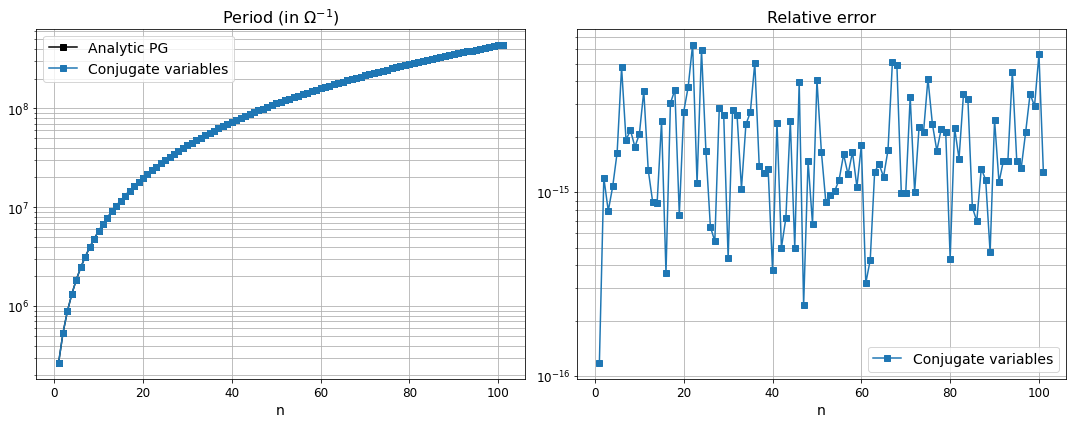

In [53]:
df_compare = df_east
compare_ref = "Analytic PG"
save_name = "./out/cases/Hydrodynamic/Recipe_Conjugate/Analytical_error"
# save_name = None
override = False

df_compare_err = pd.DataFrame()
for idx, srcname in enumerate(src_names):
    df_compare_err[srcname] = np.abs(df_compare[compare_ref] - df_compare[srcname])/np.abs(df_east[compare_ref])
display(df_compare_err.transpose().style.format(formatter=lambda x: "{:.3e}".format(x)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax = axes[0]
ax.semilogy(n_eigs, 2*np.pi*1e+4/np.abs(np.imag(df_compare[compare_ref])), 'ks-', label=compare_ref)
for idx, srcname in enumerate(src_names):
    ax.semilogy(n_eigs, 2*np.pi*1e+4/np.abs(np.imag(df_compare[srcname])), 's-', label=srcname)
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_xlabel("n", fontsize=14)
ax.set_title("Period (in $\Omega^{-1}$)", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax = axes[1]
for idx, srcname in enumerate(src_names):
    ax.semilogy(n_eigs, df_compare_err[srcname], 's-', label=srcname)
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_xlabel("n", fontsize=14)
ax.set_title("Relative error", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.pdf') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.pdf', format="pdf", bbox_inches="tight")
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")
plt.show()

## Eigenmode visualization

### Select results

#### Read in PG form

In [41]:
from pg_utils.pg_model import core, base, params
from pg_utils.pg_model import expansion as xpd
from pg_utils.numerics import matrices as nmatrix


eigenfile = "./out/cases/Malkus/Full_recipe_Daria_thesis/Eigen.h5"
from pg_utils.pg_model import expand_daria_thesis as xpd_cfg

with h5py.File(eigenfile, 'r') as fread:
    xpd_identifier = fread.attrs["xpd"]
    azm_val = fread.attrs["azm"]
    Le_val = fread.attrs["Le"]
    Lu_val = fread.attrs["Lu"]
    cnames = list(fread["bases"]["names"].asstr()[()])
    ranges_trial = fread["bases"]["ranges"][()]
    eig_vals = fread["eigval"][()]
    eig_vecs = fread["eigvec"][()]

# Sort east-west modes
eigidx_east = np.arange(eig_vals.size)[np.imag(eig_vals) < -1e-7]
eigidx_west = np.arange(eig_vals.size)[np.imag(eig_vals) > +1e-7]
eigval_east = eig_vals[eigidx_east]
eigval_west = eig_vals[eigidx_west]
eigvec_east = eig_vecs[:, eigidx_east]
eigvec_west = eig_vecs[:, eigidx_west]

fnames = xpd_cfg.field_names

# Physical params
physical_params = {
    core.t: 0,
    xpd.m: azm_val,
    params.Le: Le_val
}

# Expansion range
field_nrange = {fname: ranges_trial[i_field] for i_field, fname in enumerate(fnames)}
field_nrange["U_s"] = field_nrange["Psi"]
field_nrange["U_p"] = field_nrange["Psi"]
field_nrange["U_z"] = field_nrange["Psi"]
field_nrange["Zeta"] = field_nrange["Psi"]

In [42]:
xpd_cfg.identifier, xpd_identifier

('expand_daria_thesis_mode_eigen', 'expand_daria_thesis_mode_eigen')

Configure the expansion

In [43]:
field_func = pproc.get_eigen_field_function(xpd_cfg.recipe, physical_params)

Select an eigenvalue to visualize

In [44]:
mode, idx = "fast", 5
if mode == "fast":
    eigval, eigvec = eigval_east[idx], eigvec_east[:, idx]
elif mode == "slow":
    eigval, eigvec = eigval_west[idx], eigvec_west[:, idx]

eigvec = nmatrix.LabeledBlockArray(eigvec, cnames, ranges_trial)
eigvec = base.LabeledCollection(cnames, 
    **{cname: eigvec[cname] for cname in cnames})
map_coeff_vals = base.map_collection(xpd_cfg.recipe.rad_xpd.coeffs, eigvec)

#### Read in conjugate form

In [6]:
from pg_utils.pg_model import core, base, params
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import expand_conjugate as xpd_cfg
from pg_utils.numerics import matrices as nmatrix


# eigenfile = "./out/cases/Malkus/Conjugate_recipe/Eigen.h5"
eigenfile = "./out/cases/Hydrodynamic/Recipe_Conjugate/Eigen_N10.h5"

with h5py.File(eigenfile, 'r') as fread:
    xpd_identifier = fread.attrs["xpd"]
    azm_val = fread.attrs["azm"]
    Le_val = fread.attrs["Le"]
    Lu_val = fread.attrs["Lu"]
    cnames = list(fread["bases"]["names"].asstr()[()])
    ranges_trial = fread["bases"]["ranges"][()]
    eig_vals = fread["eigval"][()]
    eig_vecs = fread["eigvec"][()]

# Sort east-west modes
eigidx_east = np.arange(eig_vals.size)[np.imag(eig_vals) < -1e-7]
eigidx_west = np.arange(eig_vals.size)[np.imag(eig_vals) > +1e-7]
eigval_east = eig_vals[eigidx_east]
eigval_west = eig_vals[eigidx_west]
eigvec_east = eig_vecs[:, eigidx_east]
eigvec_west = eig_vecs[:, eigidx_west]

# fnames = xpd_cfg.field_names
fnames = base.CollectionPG.pg_field_names

# Physical params
physical_params = {
    core.t: 0,
    xpd.m: azm_val,
    params.Le: Le_val
}

# Expansion range
field_nrange = {fname: ranges_trial[1] if 'M' in fname else ranges_trial[0] for fname in fnames}
field_nrange["U_s"] = field_nrange["Psi"]
field_nrange["U_p"] = field_nrange["Psi"]
field_nrange["U_z"] = field_nrange["Psi"]
field_nrange["Zeta"] = field_nrange["Psi"]

Configure the expansion

In [7]:
field_func = pproc.eigen_func_from_conjugate(xpd_cfg.recipe, physical_params)

Select an eigenvalue to visualize

In [18]:
mode, idx = "east", 5
if mode == "east":
    eigval, eigvec = eigval_east[idx], eigvec_east[:, idx]
elif mode == "west":
    eigval, eigvec = eigval_west[idx], eigvec_west[:, idx]

eigvec = nmatrix.LabeledBlockArray(eigvec, cnames, ranges_trial)
eigvec = base.LabeledCollection(cnames, 
    **{cname: eigvec[cname] for cname in cnames})
map_coeff_vals = base.map_collection(xpd_cfg.recipe.rad_xpd.coeffs, eigvec)

### Radial plot

For radial plot, $\phi=Cst$, $z=Cst$.

In [19]:
p_cst = np.pi/4
z_cst = 0
s_array = np.linspace(0, 1, num=100)

Alternatively, one can use a list of s points corresponding to spacing in $\xi$

In [20]:
from scipy import special as specfun

xi_array, _ = specfun.roots_chebyt(100)
s_array = np.r_[0, np.sqrt((1 + xi_array)/2), 1]

Calculate all fields

In [21]:
def calc_field_rad(fname, field_f):
    # print(fname)
    S_mesh, N_mesh = np.meshgrid(s_array, np.arange(field_nrange[fname]), indexing='ij')
    eval_tmp = field_f(S_mesh, p_cst, z_cst, N_mesh, *[vec for vec in eigvec])
    if np.array(eval_tmp).ndim == 0:
        return eval_tmp*np.ones_like(S_mesh[...,0])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_rad, inplace=False, metadata=True)

Plot all fields

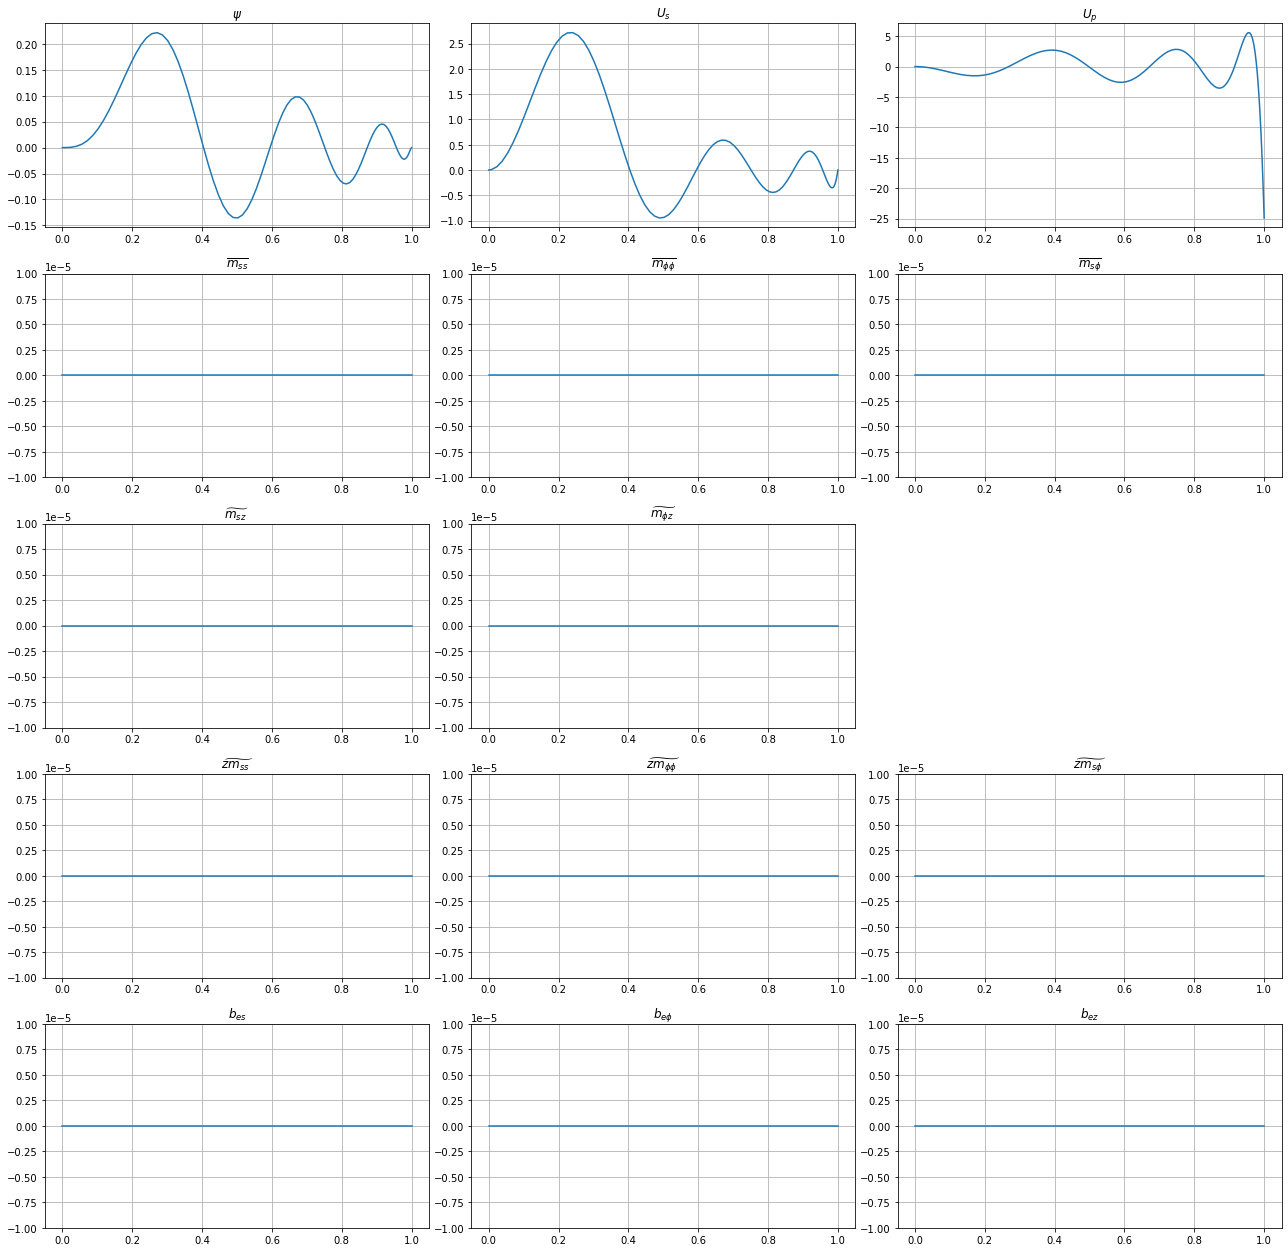

In [22]:
plot_fields = [["Psi", "U_s", "U_p"],
               ["Mss", "Mpp", "Msp"], 
               ["Msz", "Mpz", None], 
               ["zMss", "zMpp", "zMsp"], 
               ["Bs_e", "Bp_e", "Bz_e"]]

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*3.5))

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        ax.plot(s_array, np.real(eigmode_eval[fname]))
        if np.abs(np.real(eigmode_eval[fname])).max() < 1e-5:
            ax.set_ylim([-1e-5, +1e-5])
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar_ptb[fname].name,))
        else:
            ax.set_title(r'$%s$' % (fname,))
        ax.grid(True)

plt.tight_layout()
plt.savefig("./out/cases/Hydrodynamic/Recipe_Conjugate/m3n5_radial.png", format="png", dpi=120, bbox_inches="tight")
plt.show()

### Equatorial plane plot

For Equatorial plane section, $z=0$. $s$ and $p$ form a mesh of grid points.

In [28]:
z_cst = 0
s_array = np.linspace(0, 1, num=100)
p_array = np.linspace(0, 2*np.pi, num=400)
S_mesh, P_mesh = np.meshgrid(s_array, p_array)
X_mesh, Y_mesh = S_mesh*np.cos(P_mesh), S_mesh*np.sin(P_mesh)

Calculate all fields

In [29]:
def calc_field_equatorial(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, P_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([P_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, P_tmp, z_cst, N_tmp, *[vec for vec in eigvec])
    if np.array(eval_tmp).ndim == 0:
        return eval_tmp*np.ones_like(S_mesh[...,0])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_equatorial, inplace=False, metadata=True)

Plot all fields

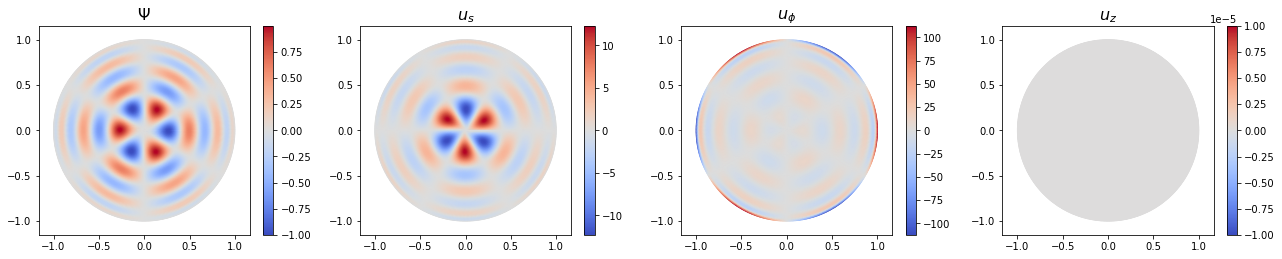

In [31]:
# plot_fields = [["Psi", "U_s", "U_p", "U_z"],
#                ["Mss", "Mpp", "Msp", "zMsp"], 
#                ["Msz", "Mpz", "zMss", "zMpp"], 
#                ["Bs_e", "Bp_e", "Bz_e", "Zeta"]]
# plot_fnames = [[None, r"$u_s$", r"$u_\phi$", r"$u_z$"],
#                [None, None, None, None], 
#                [None, None, None, None], 
#                [None, None, None, r"$\zeta$"]]
plot_fields = [["Psi", "U_s", "U_p", "U_z"],]
plot_fnames = [[None, r"$u_s$", r"$u_\phi$", r"$u_z$"],]
# save_name = None
save_name = "./out/cases/Hydrodynamic/Recipe_Conjugate/m3n5_eqplot_U"
override = False

# max_norm = max([np.abs(np.real(eigmode_eval[plot_fields[i_r][i_c]])).max() 
#                 for i_r in range(nrows) for i_c in range(ncols) 
#                 if plot_fields[i_r][i_c] is not None and plot_fields[i_r][i_c] != "Zeta"])
max_norm = np.abs(np.real(eigmode_eval["Psi"])).max()

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.5, nrows*3.7))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.abs(np.real(eigmode_eval[fname])).max() > 1e-5:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,), fontsize=16)
        else:
            ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        ax.axis("equal")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

### Meridional plane plot

For meridional plane section, $\phi=Cst$. $s$ and $z$ form a mesh of grid points.

In [32]:
p_cst = np.pi/4
r_array = np.linspace(0, 1, num=100)
theta_array = np.linspace(0, np.pi/2, num=100)
R_mesh, T_mesh = np.meshgrid(r_array, theta_array)
S_mesh, Z_mesh = R_mesh*np.sin(T_mesh), R_mesh*np.cos(T_mesh)

Calculate all fields

In [33]:
def calc_field_meridional(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, p_cst, Z_tmp, N_tmp, *[vec for vec in eigvec])
    if np.array(eval_tmp).ndim == 0:
        return eval_tmp*np.ones_like(S_mesh[...,0])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_meridional, inplace=False, metadata=True)

Plot fields.

Note: physically, only plotting the fields defined in 3-D space make sense. Therefore, none of the PG variables have meridional plot, as all of the fields are defined in 2-D (most in the unit disk, $B_r$ on the surface of the sphere).

The only field with full volumetric definition is the velocity field, which of course takes the form of the ansatz.

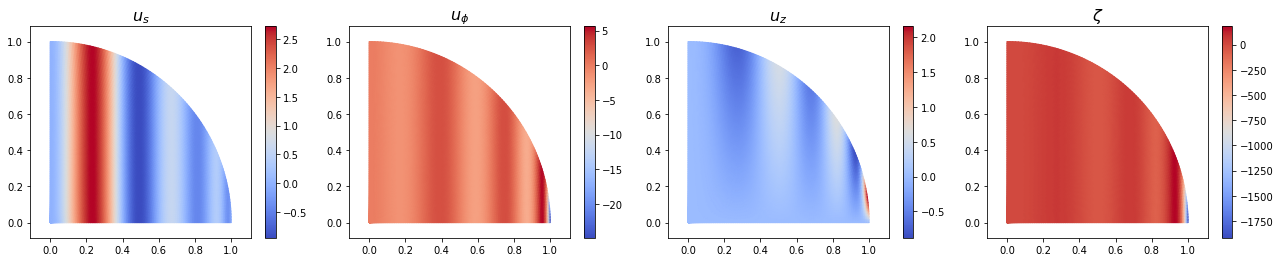

In [64]:
plot_fields = [["U_s", "U_p", "U_z", "Zeta"],]
plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$", r"$\zeta$"],]
save_name = None
# save_name = "./out/cases/Malkus/Conjugate_recipe/m3n5_sympy_mdplot"
override = False

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.5, nrows*3.75))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.real(eigmode_eval[fname]).max() > 1e-5:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,), fontsize=16)
        else:
            ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        ax.axis("equal")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

### Meridional semislice

For meridional plane section, $\phi=Cst$. $s$ and $z$ form a mesh of grid points.

In [34]:
p_cst = np.pi/4
r_array = np.linspace(0, 1, num=100)
theta_array = np.linspace(0, np.pi, num=100)
R_mesh, T_mesh = np.meshgrid(r_array, theta_array)
S_mesh, Z_mesh = R_mesh*np.sin(T_mesh), R_mesh*np.cos(T_mesh)

Calculate all fields

In [35]:
eigmode_eval = field_func.apply(calc_field_meridional, inplace=False, metadata=True)

Plot fields.

Note: physically, only plotting the fields defined in 3-D space make sense. Therefore, none of the PG variables have meridional plot, as all of the fields are defined in 2-D (most in the unit disk, $B_r$ on the surface of the sphere).

The only field with full volumetric definition is the velocity field, which of course takes the form of the ansatz.

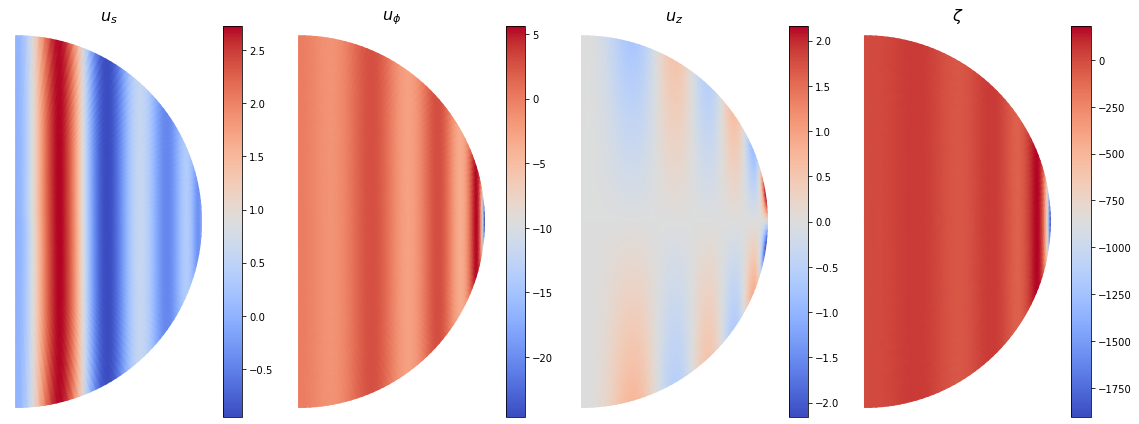

In [40]:
plot_fields = [["U_s", "U_p", "U_z", "Zeta"],]
plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$", r"$\zeta$"],]
# plot_fields = [["Zeta", "U_z", "U_p", "U_s",],]
# plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$", r"$\zeta$"],]
# save_name = None
save_name = "./out/cases/Hydrodynamic/Recipe_Conjugate/m3n5_mdplot"
override = False

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*6))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.real(eigmode_eval[fname]).max() > 1e-5:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            # plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,), fontsize=16)
        else:
            ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        ax.axis("equal")
        ax.axis("off")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

### Output to 3-D visualization

In [115]:
r_array = np.arange(0.05, 1, 0.1)
theta_array = np.arange(0, 181, 5)
phi_array = np.arange(0, 360, 5)

R_mesh, Phi_mesh, Theta_mesh = np.meshgrid(r_array, np.radians(phi_array), np.radians(theta_array), indexing='ij')
S_mesh = R_mesh*np.sin(Theta_mesh)
Z_mesh = R_mesh*np.cos(Theta_mesh)

def calc_field_3d(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, P_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Phi_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, P_tmp, Z_tmp, N_tmp, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

Zeta_mesh = calc_field_3d("Zeta", field_func.Zeta)
Uz_mesh = calc_field_3d("U_z", field_func.U_z)

In [117]:
np.savez("./out/cases/Malkus/3darray.npz", r_array=r_array, theta_array=theta_array, phi_array=phi_array, Zeta=Zeta_mesh, Uz=Uz_mesh)

## Spectrum

### Conjugate variables formulation

In [54]:
from pg_utils.pg_model import core, base, params
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import expand_conjugate as xpd_cfg
from pg_utils.numerics import matrices as nmatrix

field_names = base.CollectionConjugate.cg_field_names

eigen_files = {
    # <Truncation order>: <File name>
    # 5: "./out/cases/Malkus/Conjugate_recipe/Eigen.h5", 
    # 100: "./out/cases/Malkus/Conjugate_recipe/Eigen_N100.h5",
    10: "./out/cases/Hydrodynamic/Recipe_Conjugate/Eigen_N10.h5", 
    100: "./out/cases/Hydrodynamic/Recipe_Conjugate/Eigen_N100.h5", 
}

trunc_orders = sorted(list(eigen_files.keys()))
files_list = [eigen_files[Ntrunc] for Ntrunc in trunc_orders]

with h5py.File(files_list[0], 'r') as fread:
    xpd_identifier = fread.attrs["xpd"]
    azm_val = fread.attrs["azm"]
    Le_val = fread.attrs["Le"]
    Lu_val = fread.attrs["Lu"]
    cnames = list(fread["bases"]["names"].asstr()[()])

eigen_list = list()
for fname in files_list:
    # Read in results
    with h5py.File(fname, 'r') as fread:
        ranges_trial = fread["bases"]["ranges"][()]
        eig_vals = fread["eigval"][()]
        eig_vecs = fread["eigvec"][()]
    # Sort east-west modes
    eigidx_east = np.arange(eig_vals.size)[np.imag(eig_vals) < -1e-7]
    eigidx_west = np.arange(eig_vals.size)[np.imag(eig_vals) > +1e-7]
    eigval_east = eig_vals[eigidx_east]
    eigval_west = eig_vals[eigidx_west]
    eigvec_east = eig_vecs[:, eigidx_east]
    eigvec_west = eig_vecs[:, eigidx_west]
    # Append to list
    eigen_list.append({
        "ranges": ranges_trial,
        "eigenvalue-east": eigval_east,
        "eigenvector-east": eigvec_east,
        "eigenvalue-west": eigval_east,
        "eigenvector-west": eigvec_east
    })

# Physical params
physical_params = {
    core.t: 0,
    xpd.m: azm_val,
    params.Le: Le_val
}

# Expansion range
field_nrange = {fname: ranges_trial[1] if 'M' in fname else ranges_trial[0] for fname in field_names}

Eigenvalue

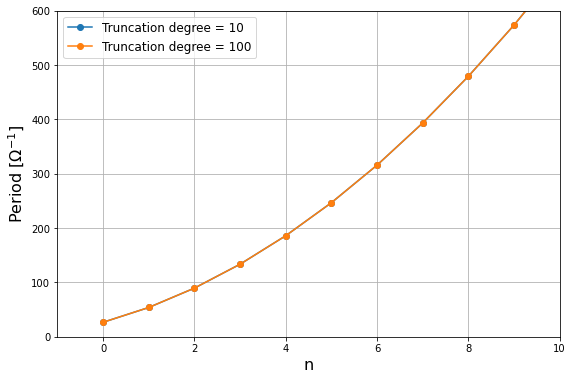

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
save_name = "./out/cases/Hydrodynamic/Recipe_Conjugate/m3_leading_10_eigenmodes"
# save_name = None

for ifile, Ntrunc in enumerate(trunc_orders):
    ax.plot(2*np.pi/np.abs(np.imag(eigen_list[ifile]["eigenvalue-east"])), 
            'o-',
            label="Truncation degree = {:d}".format(Ntrunc))

ax.set_xlabel("n", fontsize=16)
ax.set_ylabel(r"Period [$\Omega^{-1}$]", fontsize=16)
ax.legend(fontsize=12)
ax.grid()

ax.set_xlim([-1, 10])
ax.set_ylim([0, 600])

if save_name is not None:
    plt.savefig(save_name + ".pdf", format="pdf", bbox_inches="tight")
    plt.savefig(save_name + ".png", format="png", bbox_inches="tight", dpi=150)

plt.show()

Spectrum

In [57]:
# Choose which eigenmode to check
k = 7

eigen_mode_coeffs = [
    nmatrix.LabeledBlockArray(
        eigen_list[ifile]["eigenvector-east"][:, k]/np.max(np.abs(eigen_list[ifile]["eigenvector-east"][:, k])),
        field_names[:14], eigen_list[ifile]["ranges"]
    )
    for ifile in range(len(trunc_orders))
]

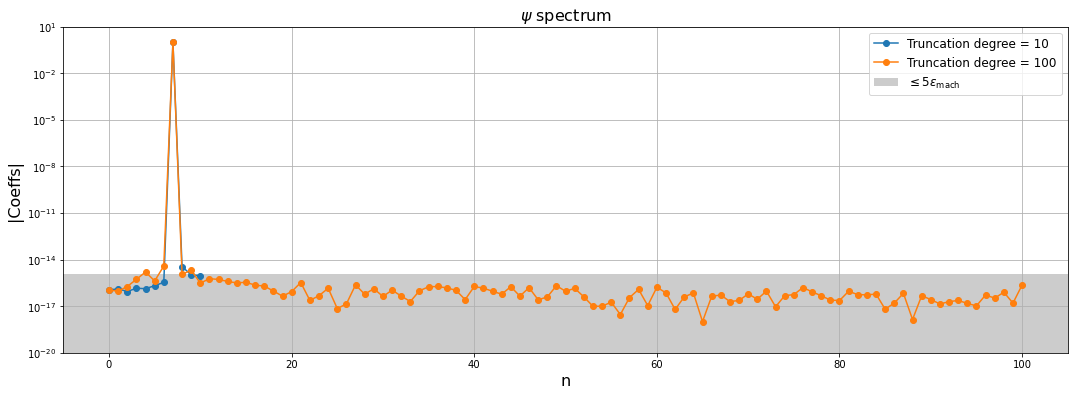

In [58]:
# Choose which field to check
field_select = "Psi"
save_name = "./out/cases/Hydrodynamic/Recipe_Conjugate/m3n%d_spectrum" % k
# save_name = None

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

for ifile, Ntrunc in enumerate(trunc_orders):
    ax.plot(np.abs(eigen_mode_coeffs[ifile][field_select]), 
            'o-',
            label="Truncation degree = {:d}".format(Ntrunc))

coeff_min = np.abs(eigen_mode_coeffs[ifile][field_select]).min()
ax.fill_between([-5, max(trunc_orders)+5], min([1e-20, coeff_min])*np.ones(2), 5*np.finfo(np.float64).eps*np.ones(2), 
    facecolor="gray", alpha=0.4, label="$\leq 5\epsilon_{\mathrm{mach}}$")

ax.set_title(r"${:s}$ spectrum".format(core.cgvar_ptb[field_select].name), fontsize=16)
ax.set_yscale("log")
ax.set_xlabel("n", fontsize=16)
ax.set_ylabel(r"|Coeffs|", fontsize=16)
ax.legend(fontsize=12)
ax.grid(which="both")

ax.set_xlim([-5, max(trunc_orders)+5])
ax.set_ylim([min([1e-20, coeff_min]), 10])

if save_name is not None:
    plt.savefig(save_name + ".pdf", format="pdf", bbox_inches="tight")
    plt.savefig(save_name + ".png", format="png", bbox_inches="tight", dpi=150)

plt.show()